In [1]:
import tensorflow as tf


import numpy as np
import matplotlib.pyplot as plt

from importlib import reload
import os

import cv2
import Augmentor as au

import unet_kkweon


from IPython import display
%matplotlib inline



In [61]:
def show(im, i = None, figsize =None):
    if len(im.shape) == 3:
        to_show = im[:,:,i]
    else:
        to_show = im
        
    if not figsize is None:
        plt.figure(figsize=(figsize))
    plt.imshow(to_show, cmap='gray')
    plt.show()
    

In [2]:
from tqdm import tqdm, tqdm_notebook
import time

In [3]:
path = "../data/stage_1_processed/"

### Load data

In [375]:
# train_names = os.listdir(path + "train")
# val_names = os.listdir(path + "val")

In [4]:
names = os.listdir("../data/stage_1_processed/")

In [5]:
train_data = [np.load(path + name) for name in names[:620]]
val_data = [np.load(path + name) for name in names[620:]]

In [377]:
# train_data = [np.concatenate((x,
#                               np.expand_dims(cv2.morphologyEx(x[:,:,1], cv2.MORPH_GRADIENT, np.ones((2,2))),2)), -1)\
#               for x in train_data ]

In [6]:
def norm_mask(x):
    x[:,:,1] = (x[:,:,1] >= 1).astype(int)
    return x
    
def norm_im(x):
    x[:,:,0] = x[:,:,0] - x[:,:,0].min()
    x[:,:,0] = x[:,:,0] / x[:,:,0].max()
    return x

train_data = [norm_im(norm_mask(x)) for x in train_data]
val_data = [norm_im(norm_mask(x)) for x in val_data]

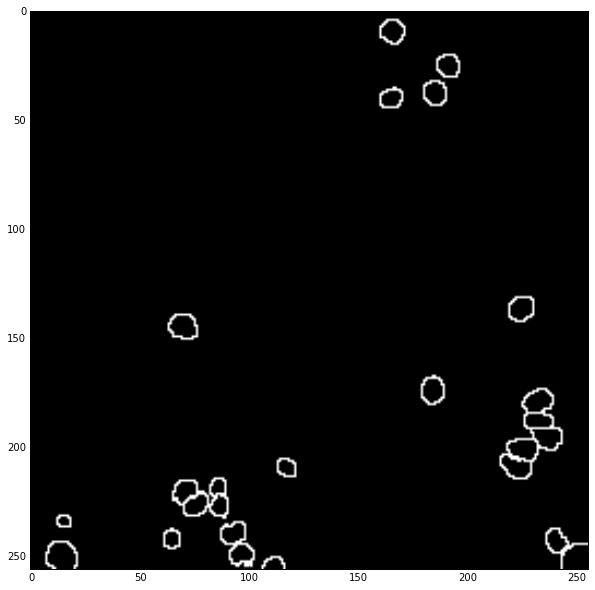

In [9]:
plt.figure(figsize = (10,10))
plt.imshow(train_data[4][:,:,2],cmap='gray')
plt.show()

### Create network and session

In [10]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [18]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [19]:
x = tf.placeholder("float", shape=[None, None, None, 1])
target = tf.placeholder("float", shape=[None, None, None, 2])
lr = tf.placeholder('float')

In [20]:
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (x)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

out = Conv2D(2, (1, 1), activation='sigmoid') (c9)

In [21]:
#out_logits = make_unet(x, training)

In [22]:
#out = tf.nn.sigmoid(out_logits)

In [23]:
#axis=np.arange(1,len(self.output_shape)+1)
offset = 1e-5
corr = tf.reduce_sum(target * out)#, axis=axis)
l2_pred = tf.reduce_sum(tf.square(out))
l2_true = tf.reduce_sum(tf.square(target))
dice_coeff = (2. * corr + 1e-5) / (l2_true + l2_pred + 1e-5)
# Second version: 2-class variant of dice loss
#corr_inv = tf.reduce_sum((1.-self.y_data_tf) * (1.-self.y_pred_tf), axis=axis)
#l2_pred_inv = tf.reduce_sum(tf.square(1.-self.y_pred_tf), axis=axis)
#l2_true_inv = tf.reduce_sum(tf.square(1.-self.y_data_tf), axis=axis)
#dice_coeff = ((corr + offset) / (l2_true + l2_pred + offset) +
#             (corr_inv + offset) / (l2_pred_inv + l2_true_inv + offset))
loss = tf.subtract(1., tf.reduce_mean(dice_coeff))

In [17]:
loss = tf.reduce_mean(tf.losses.log_loss(target, out))

#loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(target, out_logits))
#loss = mean_iou(out, target)

In [24]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr, beta2=0.98)
train_step = optimizer.minimize(loss)

In [25]:
uninitialized_vars = []
for var in tf.all_variables():
    try:
        sess.run(var)
    except tf.errors.FailedPreconditionError:
        uninitialized_vars.append(var)

init_new_vars_op = tf.initialize_variables(uninitialized_vars)
sess.run(init_new_vars_op)

Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.


In [561]:
sess.run(tf.global_variables_initializer())

In [562]:
gr = tf.get_default_graph()

writer = tf.summary.FileWriter("../tf_logs", gr)

### Augmentation + batch_iterator

In [26]:
def mirror(im):
    shape = im.shape
    h = lambda arr: np.hstack((arr[:,(shape[1] // 2)::-1,:], arr, arr[:,:(shape[1] // 2):-1,:]))
    v = lambda arr: np.vstack((arr[shape[0] // 2::-1,:,:], arr, arr[:shape[0] // 2:-1,:,:]))

    return v(h(im))

In [27]:
u16_up = lambda x : int((x // 16 + 1) * 16)
u16_d = lambda x : int((x // 16) * 16)

In [28]:
def crop(im, shape=None):
    if shape is None:
        shape = (u16_d(im.shape[0] * 0.7), u16_d((im.shape[1] * 0.7)))
    #shape = (min(512, im.shape[0] - 1), min(512, im.shape[1] - 1))
    x = np.random.randint(0, im.shape[0] - shape[0])
    y = np.random.randint(0, im.shape[1] - shape[1])
    
    excerpt_x = slice(x, x+shape[0])
    excerpt_y = slice(y, y+shape[1])
    
    return im[excerpt_x, excerpt_y, :]

In [29]:
def get_16_im(im):
    shape = im.shape
    big_im = mirror(im)
    pos_x = shape[0] // 2
    pos_y = shape[1] // 2
    
    
    shape_shift = (u16_up(shape[0]), u16_up(shape[1]))
    
    #prediction = sess.run(sigmoid_out, feed_dict={x : np.expand_dims(big_im[x: x + shape_shift[0], y : y + shape_shift[1], :], 0), training : False})
    return big_im[pos_x: pos_x + shape_shift[0], pos_y : pos_y + shape_shift[1],:]

In [30]:
import revertable_augmentator as ra
from importlib import reload
ra = reload(ra)

In [31]:
def iterate_minibatches(x, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(len(x))
        np.random.shuffle(indices)
    for start_idx in range(0, len(x) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield x[excerpt]

## Prediction

In [32]:
def validate(data,prediction_func,cut_off=0.5):
    predictions = [prediction_func(im[:,:,:1]) for im in data]
    ground_truth = [im[:,:,1:2] for im in data]
    
    MAP = 0
    for t,p in tqdm(zip(ground_truth, predictions)):
        
        MAP += calculate_average_precision([x for x in prob_to_masks(t,cut_off)], [x for x in prob_to_masks(p,cut_off)])
    
    return MAP / len(predictions)

In [33]:
def validate_simple(data, prediction_func, cut_off=0.5):
    predictions = [prediction_func(im[:,:,:1]) for im in data]
    ground_truth = [im[:,:,1:2] for im in data]
    
    IOU = 0
    for t,p in tqdm(zip(ground_truth, predictions)):
        #MAP += calculate_average_precision([x for x in prob_to_masks(t)], [x for x in prob_to_masks(p)])
        IOU += np.logical_and(t,p > cut_off).sum() / np.logical_or(t,p > cut_off).sum()

    return IOU / len(predictions)

In [128]:
def crop(im, shape=None):
    if shape is None:
        shape = (u16_d(im.shape[0] * 0.7), u16_d((im.shape[1] * 0.7)))

    #shape = (min(512, im.shape[0] - 1), min(512, im.shape[1] - 1))
    x = np.random.randint(0, im.shape[0] - shape[0])
    y = np.random.randint(0, im.shape[1] - shape[1])
    
    excerpt_x = slice(x, x+shape[0])
    excerpt_y = slice(y, y+shape[1])
    
    return im[excerpt_x, excerpt_y, :]

In [129]:
def transform(im):
    transformation = ra.Transformation.generate_random_transformation(mirror(im))
    #transformation = ra.Transformation.generate_geometrical(mirror(im))
    return crop(transformation.apply(mirror(im)), im.shape)

In [130]:
ra=reload(ra)
#imgs = np.array([transform(im) for im in train_data[:]])

In [41]:
train_loss = []
val_scores = []
val_loss = []

In [134]:
epochs = 10

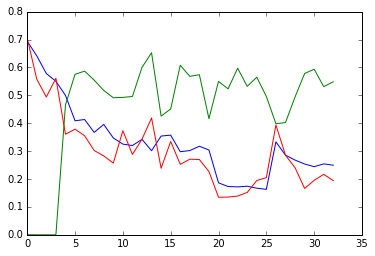

KeyboardInterrupt: 

In [135]:
for epoch in range(epochs):
    curr_loss = 0
    imgs = np.array([transform(im) for im in train_data[:]])
    #imgs = np.array([im for im in train_data[:]])
    for i, (batch) in tqdm(enumerate(iterate_minibatches(imgs[:],20))):
        shapes = np.concatenate(([np.array(image.shape).reshape(1, -1) for image in batch]))
        batch_shape = (u16_d(shapes[:,0].min() - 1), u16_d(shapes[:,1].min() - 1))
        images = [crop(im, batch_shape) for im in batch]
        
        batch_x = np.concatenate([np.expand_dims(im[:,:,:1],0) for im in images], 0)
        batch_y = np.concatenate([np.expand_dims(im[:,:,1:],0) for im in images], 0)

        
        batch_loss = sess.run([train_step,loss], feed_dict={x : batch_x, target: batch_y, lr : 0.001})
        curr_loss += batch_loss[1]

    train_loss.append(curr_loss / (i + 1)) 
    
    val_score = validate_simple(val_data, predict)
    
#     if epoch != 0:
#         if val_score < val_scores[-1]:
#             save_model("../model/model_1/")
            
            
    val_scores.append(val_score)
    val_loss.append(sess.run(loss, feed_dict={x:batch_x, target:batch_y}))
    
    display.clear_output(wait=True)
    plt.plot(train_loss, label='train')
    plt.plot(val_scores, label='test')
    plt.plot(val_loss, label='test')

    plt.show()
            

In [1151]:
import pickle

In [1152]:
def save_state():
    state = {}
    for var in tf.all_variables():
        state[var.name] = sess.run(var)
    return state

pickle.dump(save_state, open("../model/begining_of_dice", 'wb'))

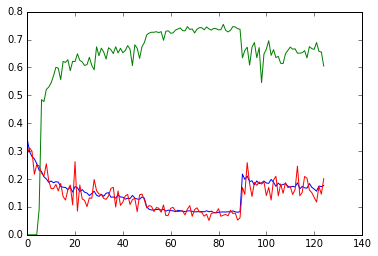

In [1173]:
plt.plot(train_loss, label='train')
plt.plot(val_scores, label='test')
plt.plot(val_loss, label='test')
#plt.legend()
plt.show()

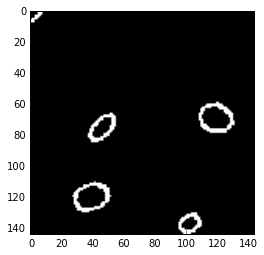

In [1171]:
show(batch_y[2],1)

In [61]:
val_score = validate_simple(val_data, predict)
    
#     if epoch != 0:
#         if val_score < val_scores[-1]:
#             save_model("../model/model_1/")
            
            
val_scores.append(val_score)
val_loss.append(sess.run(loss, feed_dict={x:batch_x, target:batch_y, training:0}))

44it [00:00, 763.29it/s]


In [571]:
val_score = validate_simple(val_data, predict)

44it [00:00, 616.61it/s]


In [572]:
val_score

0.0

In [77]:
batch_y.min()

0.0

In [79]:
batch_x.max()

1.0

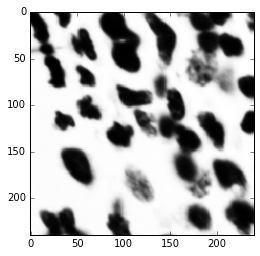

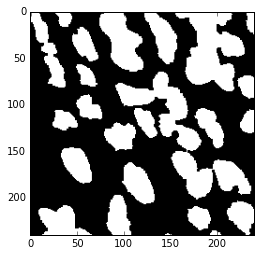

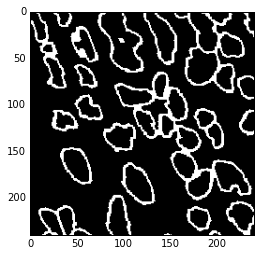

In [169]:
#pred = predict(batch_y[0])
ind = 13
plt.imshow(batch_x[ind][:,:,0], cmap = 'gray')
plt.show()
plt.imshow(batch_y[ind][:,:,0], cmap = 'gray')
plt.show()
plt.imshow(batch_y[ind][:,:,1], cmap = 'gray')
plt.show()

In [820]:
ra=reload(ra)

In [162]:
proba = predict_proba(batch_x[12][:,:,:1])


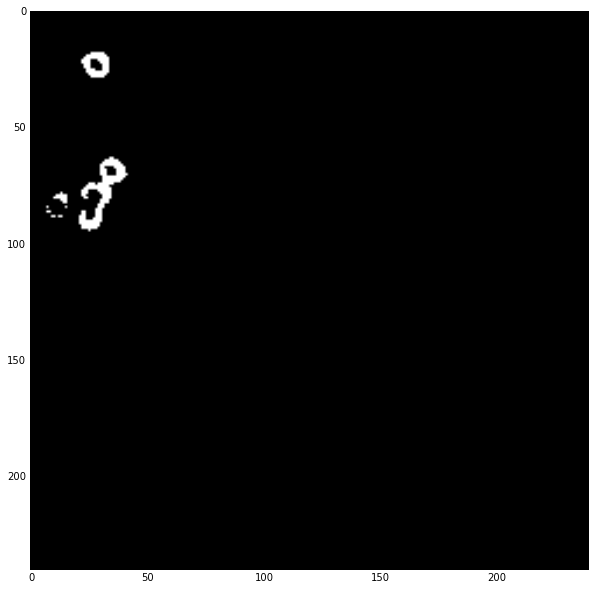

In [163]:
show((proba[:,:,1]) > 0.5, figsize=(10,10))

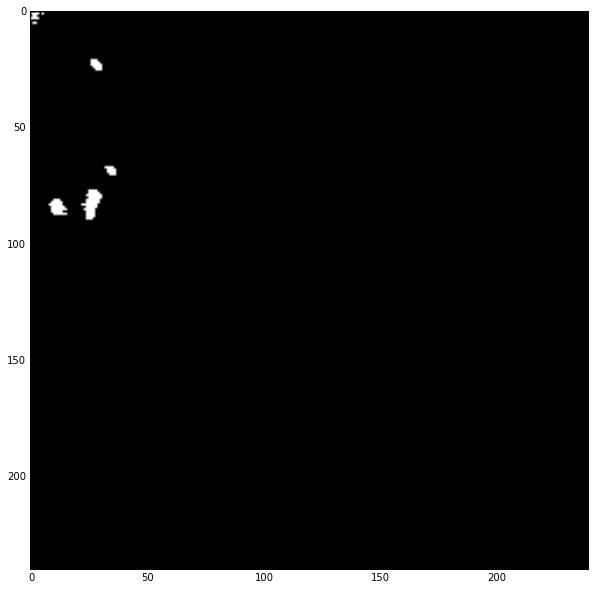

In [166]:
show((proba[:,:,0] - proba[:,:,1]) > 0.5, figsize=(10,10))

In [647]:
def predict_resize(im, steps = 2):
    shape = im.shape
    im_16 = get_16_im(im)

    #prediction = sess.run(out, feed_dict={x : np.expand_dims(im_16, 0), training : 0})[0]
    prediction = np.zeros([shape[0], shape[1], 2])
    
    for i in np.linspace(0.9, 1.1, 2*steps - 1):
        #print(i)
        trnsf = ra.Transformation(im_16, ratios=np.array([1,1]) * i)
        im_resized = trnsf.apply(im_16, True)
        shape_resized = im_resized.shape
        
        im_resized_16 = get_16_im(im_resized)
        pred_resized = sess.run(out, feed_dict={x : np.expand_dims(im_resized_16, 0)})[0][:shape_resized[0],:shape_resized[1]]
        
        
        trnsf_inv = ra.Transformation(pred_resized, ratios=np.array([1,1]) / i)
        
        pred_original_shape = cv2.morphologyEx(trnsf_inv.apply(pred_resized, False)[:shape[0],:shape[1]], cv2.MORPH_CLOSE, np.ones((3,3)))
        
#         print(pred_resized.max())
#         show(pred_original_shape,0)
#         print(pred_original_shape.max())
        prediction += pred_original_shape
        
    #prediction = prediction[:,:,0]
    return prediction / (2*steps -1)

In [648]:
import skimage

In [39]:
def predict_flip(im):
    shape = im.shape
    if im.shape[0] > 1000 and im.shape[1] > 1000:
        im_pred = skimage.exposure.adjust_gamma(im, 0.3)
    else:
        im_pred = im.copy()
    im_16 = get_16_im(im_pred)
    #im_16 = im
    prediction = sess.run(out, feed_dict={x : np.expand_dims(im_16, 0)})[0] +\
                sess.run(out, feed_dict={x : np.expand_dims(im_16[::-1], 0)})[0][::-1] +\
                sess.run(out, feed_dict={x : np.expand_dims(im_16[:,::-1], 0)})[0][:,::-1] +\
                sess.run(out, feed_dict={x : np.expand_dims(im_16[::-1,::-1], 0)})[0][::-1,::-1]
    prediction = prediction[:,:,0] - prediction[:,:,1]
    #rediction = prediction[:,:,0]
    
    prediction = prediction / 4
    prediction = prediction[:shape[0],:shape[1]]
    
    circle5=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    prediction = cv2.morphologyEx(prediction, cv2.MORPH_OPEN, circle5)
    rediction = cv2.morphologyEx(prediction, cv2.MORPH_CLOSE, circle5)
    
    return np.expand_dims(prediction,2)

In [63]:
from skimage.morphology import label
def predict_proba(im):
    shape = im.shape
    im_16 = get_16_im(im)
    #im_16 = im
    prediction = sess.run(out, feed_dict={x : np.expand_dims(im_16, 0)})[0]    
    
    prediction = prediction[:shape[0],:shape[1]]
    #prediction = prediction[:,:,0] - prediction[:,:,1]
    
    #circle3=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    #prediction = cv2.morphologyEx(prediction, cv2.MORPH_OPEN, circle3)
        
    return prediction

In [1098]:
def predict_random(im, num = 5):
    shape = im.shape[:2]
    party_pred = np.expand_dims(np.zeros(shape),2)
    
    im_m = mirror(im.copy())
    
    trfs = [ra.Transformation(im_m.copy(), 0,1,1,1,-5,10,np.array([1,1])),
            ra.Transformation(im_m.copy(), 1,1,1,1,-5,10,np.array([1,1])),
            ra.Transformation(im_m.copy(), 0,0.5,0,0,5,-10,np.array([1,1])),
            ra.Transformation(im_m.copy(), 1,1,1,1,5,-10,np.array([1,1])),
            ra.Transformation(im_m.copy(), 0,1,0,0,0,0,np.array([1,1])),
           ]
    
#     for i in range(num):
#         im_m = mirror(im.copy())
#         trf = ra.Transformation.generate_random_transformation(im_m)
    for trf in trfs[:num]:
        im_to_pred = trf.apply(im_m)
        pred = predict_flip(im_to_pred[:,:,:1]) # > 0.5).astype(int)[:,:,:]           
                    
        pred_inv = trf.apply_inverse(pred)[pred.shape[0] // 4 : pred.shape[0] // 4 + shape[0],
                                          pred.shape[1] // 4 : pred.shape[1] // 4 + shape[1]]
        
        
        party_pred += pred_inv

                      
    return party_pred / num

In [1017]:
pred = (predict_random(val_data[ind], 5) > 0.5)[:,:,0]

In [1021]:
ind = 6
#pred = (predict_flip(skimage.exposure.adjust_gamma(val_data[ind], 1)[:,:,:1]) > 0.5)[:,:,0]

In [1022]:
pred = (predict_random(val_data[ind], 5) > 0.5)[:,:,0]

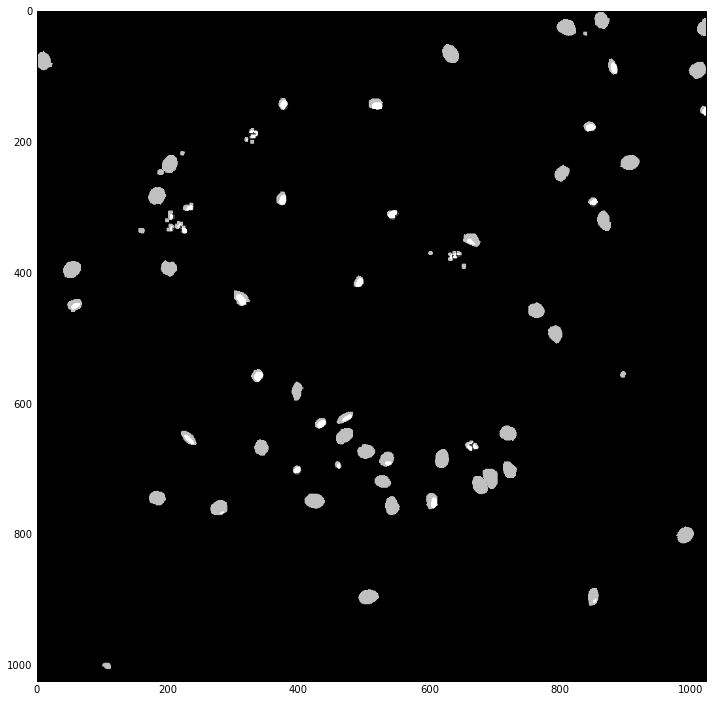

In [1023]:
show(pred[:,:] + val_data[ind][:,:,1] * 3 ,figsize= (12,12))

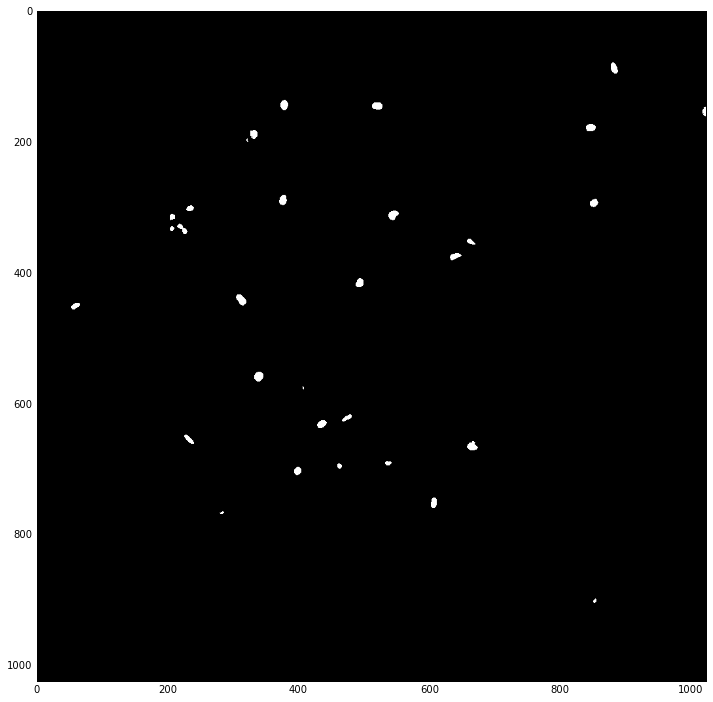

In [1024]:
show(pred, 0  ,figsize= (12,12))

In [970]:
val_data[ind]

(256, 320, 3)

In [936]:
trf = ra.Transformation(val_data[ind].copy(), 0,1,1,1,-5,10,np.array([1.1,1.1]))
val_impr = trf.apply(val_data[ind].copy())


In [953]:
ind = 15
pred = (predict_flip(val_impr[:,:,:1]) > 0.5).astype(int)[:,:,:]

In [956]:
pred_inv = trf.apply_inverse(pred)

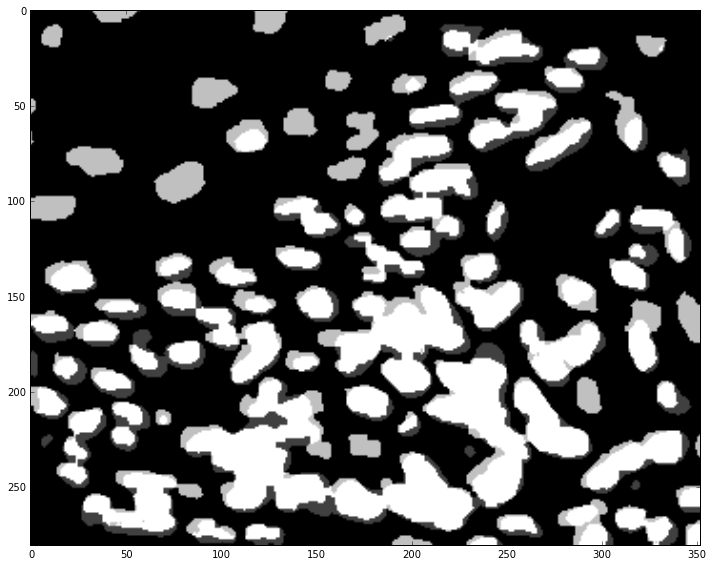

In [938]:
show(pred[:,:] + val_impr[:,:,1] * 3 ,figsize= (12,12))

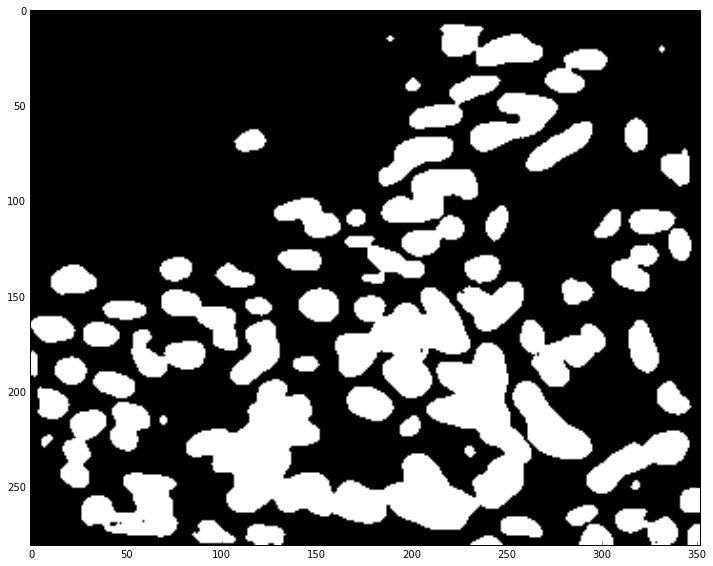

In [939]:
show(pred,0  ,figsize= (12,12))

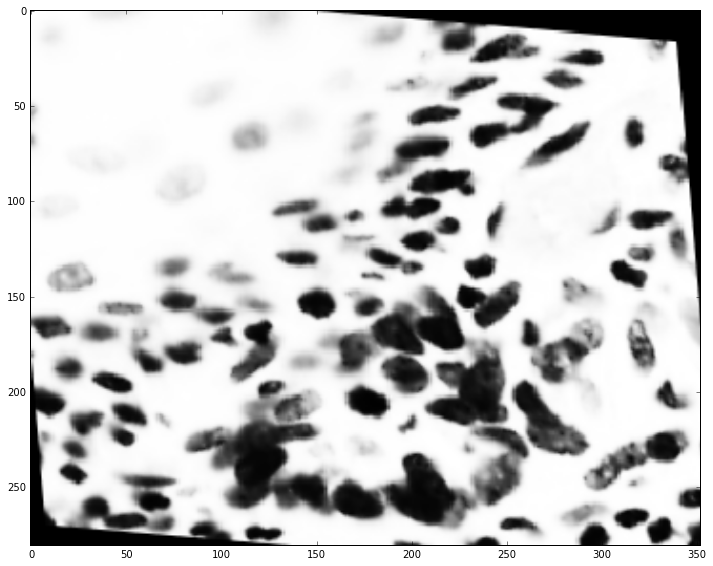

In [940]:
show(val_impr, 0  ,figsize= (12,12))

In [573]:
val_data[0][:,:,0].max()

1.0

In [763]:
validate_simple(val_data[:], predict_flip)

44it [00:00, 719.83it/s]


0.7124797340294684

In [764]:
validate_simple(val_data[:], predict_flip)

44it [00:00, 706.47it/s]


0.7124797340294684

In [638]:
for i in np.arange(0.4, 0.5, 0.025):
    print(i, validate_simple(val_data[:], predict,i))

44it [00:00, 611.40it/s]


0.4 0.676307854978


44it [00:00, 636.59it/s]


0.425 0.68296534898


44it [00:00, 638.88it/s]


0.45 0.689383188147


44it [00:00, 609.84it/s]

0.475 0.695780034014


In [739]:
validate_simple(val_data[:], predict)

44it [00:00, 733.37it/s]


0.69717794325358073

In [825]:
validate_simple(val_data[:], predict_resize)

44it [00:00, 567.41it/s]


0.5857522154802155

In [610]:
validate(val_data[:], predict_flip)

44it [05:21,  7.30s/it]


0.28981192527041988

In [639]:
validate(val_data[:], predict_flip, 0.4)

44it [05:04,  6.93s/it]


0.23858581093751419

In [745]:
validate(val_data[:2], predict_resize)

A Jupyter Widget

0.15466333127309753

In [529]:
strange.max()

0.0047676763113807235

In [486]:
validate(val_data[:2])

2it [00:34, 17.01s/it]


0.37292384131620637

In [607]:
from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)
        
def prob_to_masks(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield (lab_img==i).astype(int)

In [608]:
def iou_at_thresholds(target_mask, pred_mask, thresholds=np.arange(0.5,1,0.05)):
    '''Returns True if IoU is greater than the thresholds.'''
    intersection = np.logical_and(target_mask, pred_mask)
    union = np.logical_or(target_mask, pred_mask)
    iou = np.sum(intersection > 0) / np.sum(union > 0)
    return iou > thresholds

def calculate_average_precision(target_masks, pred_masks, thresholds=np.arange(0.5,1,0.05)):
    '''Calculates the average precision over a range of thresholds for one observation (with a single class).'''
    iou_tensor = np.zeros([len(thresholds), len(pred_masks), len(target_masks)])

    for i, p_mask in (enumerate(pred_masks)):
        for j, t_mask in enumerate(target_masks):
            iou_tensor[:, i, j] = iou_at_thresholds(t_mask, p_mask, thresholds)

    TP = np.sum((np.sum(iou_tensor, axis=2) == 1), axis=1)
    FP = np.sum((np.sum(iou_tensor, axis=1) == 0), axis=1)
    FN = np.sum((np.sum(iou_tensor, axis=2) == 0), axis=1)

    precision = TP / (TP + FP + FN)

    return np.mean(precision)

## PREDICT

In [1036]:
path = "../data/1_stage_test_proc/"

In [1037]:
test_names = os.listdir(path)

In [1038]:
import pandas as pd

In [1099]:
sample_submition = pd.read_csv("../data/stage1_sample_submission.csv")

In [1135]:
answ = pd.DataFrame(columns=sample_submition.columns)
answ.head()

,ImageId,EncodedPixels


In [1101]:
test_preds = []
test_ims = []

In [1102]:
num = 0
for name in tqdm(test_names[:]):
    im = np.load(path + name).astype(float)
    im = norm_im(im)
    
    test_ims.append(im.copy())
    
    prediction = predict_random(im[:,:,:1], 5)[:,:,0]
    test_preds.append(prediction)
    
    
    rle_prediction = prob_to_rles(prediction, 0.5)
    for p in rle_prediction:
        answ.loc[num] = np.array([name[1:-4], ' '.join([str(el) for el in p])])
        num += 1


  6%|▌         | 4/65 [00:07<01:49,  1.80s/it]
Exception in thread Thread-383:
Traceback (most recent call last):
  File "/anaconda/envs/py35/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/anaconda/envs/py35/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 65/65 [02:04<00:00,  1.91s/it]


In [1161]:
answ.head()

,ImageId,EncodedPixels
0,c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf...,56593 4 57117 6 57641 8 58165 9 58689 10 59213...
1,c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf...,67597 12 68121 14 68645 15 69169 16 69693 17 7...
2,c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf...,80703 7 81226 11 81239 3 81745 1 81748 19 8226...
3,c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf...,146197 4 146721 5 147245 6 147769 7 148293 7 1...
4,c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf...,165585 1 166109 1 166633 1 167157 1 167681 1 1...


In [1137]:
test_names[0][1:-4]

'c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf7a082a0ace86d609eb'

In [1139]:
num = 0
for name, pred in zip(test_names, test_preds):
    rle_prediction = prob_to_rles(pred, 0.5)
    for p in rle_prediction:
        answ.loc[num] = np.array([name[1:-4], ' '.join([str(el) for el in p])])
        num += 1

In [1141]:
answ.to_csv("../data/baseline_answ.csv", index = False)

In [1158]:
test_ims[0].shape[:2]

(524, 348)

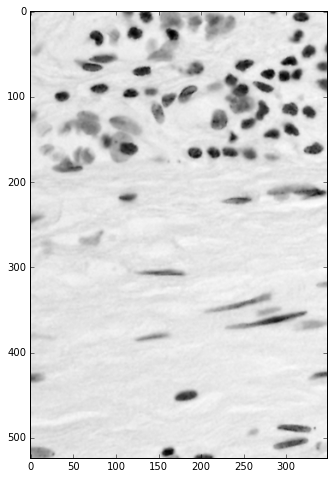

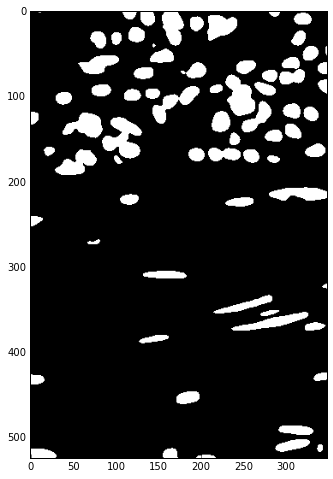

In [1162]:
idx = 0
show(test_ims[idx], 0, (8,8))
show(test_preds[idx] > 0.5, 0, (8,8))

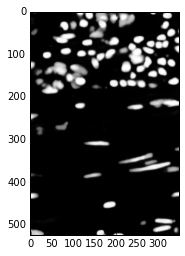

In [1126]:
show(test_preds[0], 0)

In [876]:
answ["ImageId"].values[0][:-3]

'c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf7a082a0ace86d609eb.'

In [770]:
test_data = [np.load(path + name) for name in test_names]


In [774]:
test_data = [norm_im(x) for x in test_data]

In [1066]:
show(test_data[0].astype(float),0)

NameError: name 'test_data' is not defined

In [791]:
test_pred = [predict(k[:,:,:1]) > 0.625 for k in test_data]